In [1]:
!pip install mlxtend plotly openpyxl



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from mlxtend.frequent_patterns import apriori, association_rules
import plotly.express as px


In [4]:
from google.colab import files
uploaded = files.upload()


Saving online_retail_II.xlsx to online_retail_II.xlsx


In [9]:
df1 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df2 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')

df = pd.concat([df1, df2], ignore_index=True)
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [10]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


In [11]:
df = df[~df['Invoice'].astype(str).str.startswith('C')]


In [13]:
df = df.dropna(subset=['Customer ID'])


In [14]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


/tmp/ipython-input-14-876306190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [19]:
df['TotalPrice'] = df['Quantity'] * df['Price']


/tmp/ipython-input-19-4224923631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['Price']


In [20]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [21]:
top_customers = df.groupby('Customer ID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
print(top_customers)


Customer ID
18102.0    608821.65
14646.0    528602.52
14156.0    313946.37
14911.0    295972.63
17450.0    246973.09
13694.0    196482.81
17511.0    175603.55
16446.0    168472.50
16684.0    147142.77
12415.0    144458.37
Name: TotalPrice, dtype: float64


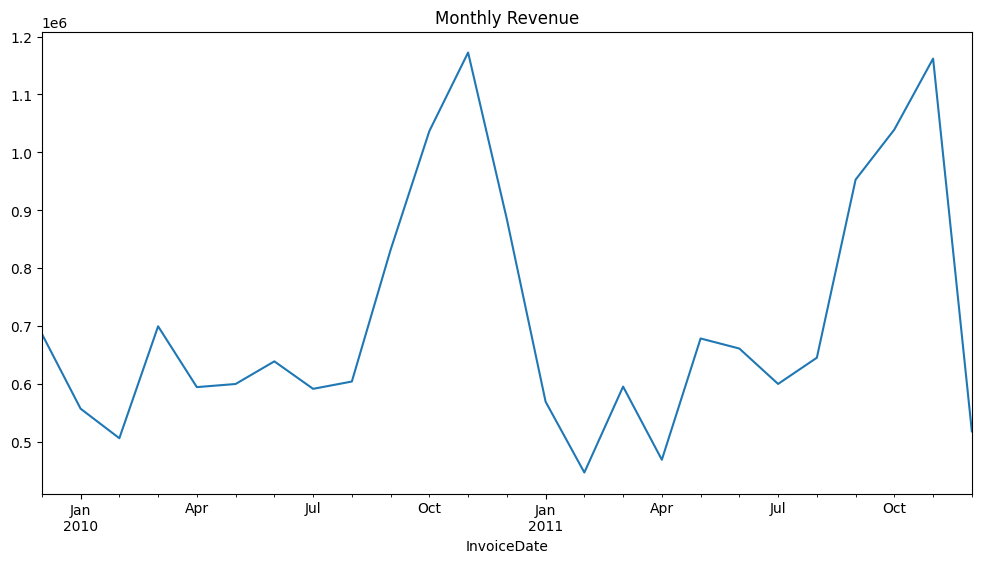

In [22]:
df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum().plot(figsize=(12,6))
plt.title("Monthly Revenue")
plt.show()

In [24]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

In [27]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

In [28]:
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,2,8,5633.32
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40


In [31]:
customer_features = df.groupby('Customer ID').agg({
    'InvoiceDate': [lambda x: (x.max() - x.min()).days, 'nunique'],
    'TotalPrice': 'sum',
    'Quantity': 'sum'
})

In [32]:
customer_features.columns = ['Lifespan', 'Frequency', 'Monetary', 'TotalQuantity']
customer_features['AOV'] = customer_features['Monetary'] / customer_features['Frequency']
customer_features['AvgBasketSize'] = customer_features['TotalQuantity'] / customer_features['Frequency']
customer_features = customer_features.reset_index()
customer_features.head()

,Customer ID,Lifespan,Frequency,Monetary,TotalQuantity,AOV,AvgBasketSize
0,12346.0,400,12,77556.46,74285,6463.038333,6190.416667
1,12347.0,402,8,5633.32,3286,704.165000,410.750000
2,12348.0,362,5,2019.40,2714,403.880000,542.800000
3,12349.0,570,4,4428.69,1624,1107.172500,406.000000
4,12350.0,0,1,334.40,197,334.400000,197.000000


/tmp/ipython-input-36-4157602357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
/tmp/ipython-input-36-4157602357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CohortIndex'] = (df['InvoiceMonth'].dt.year - df['CohortMonth'].dt.year) * 12 + (df['InvoiceMonth'].dt.month - df['CohortMonth'].dt.month) + 1


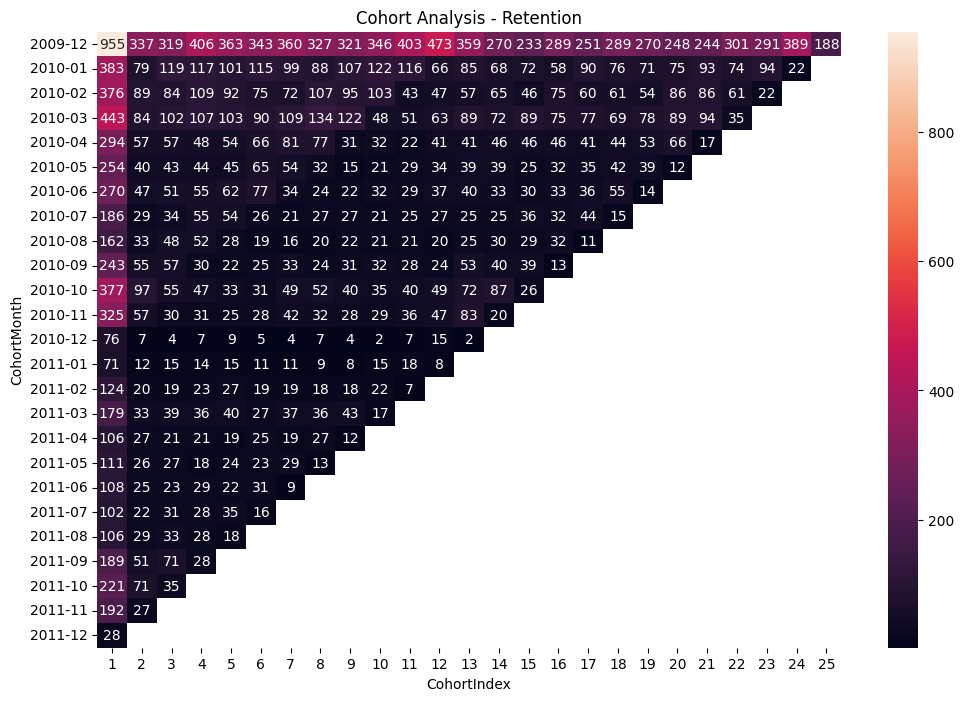

In [36]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortMonth'] = df.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')

df['CohortIndex'] = (df['InvoiceMonth'].dt.year - df['CohortMonth'].dt.year) * 12 + (df['InvoiceMonth'].dt.month - df['CohortMonth'].dt.month) + 1

cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['Customer ID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Customer ID')

plt.figure(figsize=(12,8))
sns.heatmap(cohort_pivot, annot=True, fmt='g')
plt.title('Cohort Analysis - Retention')
plt.show()

In [37]:
basket = (df[df['Country'] == "United Kingdom"]
          .groupby(['Invoice', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Invoice'))

def encode(x):
    return 1 if x >= 1 else 0

basket_sets = basket.applymap(encode)

frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

rules.head()


/tmp/ipython-input-37-149674979.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(encode)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(HEART OF WICKER SMALL),(HEART OF WICKER LARGE),0.051571,0.051303,0.025487,0.494220,9.633406,1.0,0.022842,1.875710,0.944925,0.329353,0.466869,0.495512
1,(HEART OF WICKER LARGE),(HEART OF WICKER SMALL),0.051303,0.051571,0.025487,0.496804,9.633406,1.0,0.022842,1.884811,0.944658,0.329353,0.469443,0.495512
2,(HOME BUILDING BLOCK WORD),(LOVE BUILDING BLOCK WORD),0.052704,0.043105,0.022775,0.432127,10.024981,1.0,0.020503,1.685050,0.950335,0.311837,0.406546,0.480240
3,(LOVE BUILDING BLOCK WORD),(HOME BUILDING BLOCK WORD),0.043105,0.052704,0.022775,0.528354,10.024981,1.0,0.020503,2.008490,0.940802,0.311837,0.502114,0.480240
4,(JUMBO BAG RED RETROSPOT),(JUMBO BAG STRAWBERRY),0.071275,0.043075,0.020807,0.291928,6.777176,1.0,0.017737,1.351451,0.917867,0.222435,0.260055,0.387487


In [39]:
X = customer_features[['Lifespan', 'Frequency', 'Monetary', 'AOV', 'AvgBasketSize']]
y = customer_features['Monetary']  # Or your own CLV calc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print("RMSE:", rmse)

RMSE: 36112996.37036394


In [41]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_features['Cluster'] = kmeans.fit_predict(X)

fig = px.scatter_3d(customer_features, x='Lifespan', y='Frequency', z='Monetary',
                    color='Cluster', title="Customer Segments")
fig.show()

In [42]:
customer_features.to_csv('customer_segments.csv', index=False)
from google.colab import files
files.download('customer_segments.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>